In [1]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import pathlib
data_dir = pathlib.Path("/home/mabruq/Projects/Test/mcu_data")

In [4]:
batch_size = 5
img_height = 256
img_width = 256
num_classes=3

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 153 files belonging to 3 classes.
Using 123 files for training.
Found 153 files belonging to 3 classes.
Using 30 files for validation.


In [5]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  
])


In [6]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [7]:
BATCH_SIZE = 8
IMG_SIZE = (256, 256)


In [8]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [9]:
base_model.trainable = True


In [10]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)


In [11]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)


In [12]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)


6/6 [==============================] - 2s 21ms/step - loss: 1.0719 - accuracy: 0.4248


In [16]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 1.09
initial accuracy: 0.40


In [17]:
history = model.fit(train_ds,
                    epochs=29,
                    validation_data=val_ds)


Epoch 1/29
25/25 [==============================] - 8s 161ms/step - loss: 0.8531 - accuracy: 0.5935 - val_loss: 0.4338 - val_accuracy: 0.8333
Epoch 2/29
25/25 [==============================] - 2s 95ms/step - loss: 0.3861 - accuracy: 0.8537 - val_loss: 0.4297 - val_accuracy: 0.8333
Epoch 3/29
25/25 [==============================] - 2s 94ms/step - loss: 0.3690 - accuracy: 0.8455 - val_loss: 0.4345 - val_accuracy: 0.7333
Epoch 4/29
25/25 [==============================] - 2s 95ms/step - loss: 0.2000 - accuracy: 0.9431 - val_loss: 0.2333 - val_accuracy: 0.9000
Epoch 5/29
25/25 [==============================] - 2s 94ms/step - loss: 0.3467 - accuracy: 0.8537 - val_loss: 0.1754 - val_accuracy: 0.9333
Epoch 6/29
25/25 [==============================] - 2s 94ms/step - loss: 0.1933 - accuracy: 0.9268 - val_loss: 0.1208 - val_accuracy: 0.9333
Epoch 7/29
25/25 [==============================] - 2s 93ms/step - loss: 0.2243 - accuracy: 0.9187 - val_loss: 0.4795 - val_accuracy: 0.8000
Epoch 8/29
2

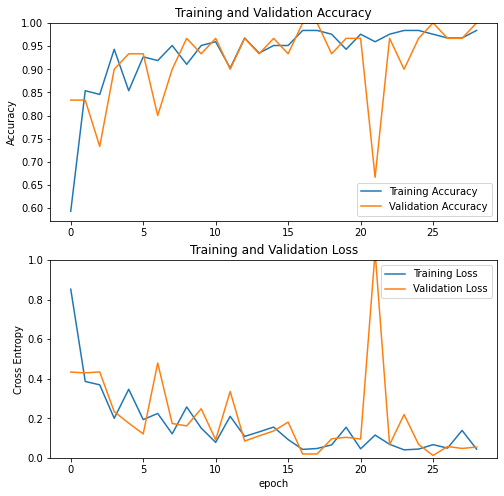

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [19]:
t = time.time()

export_path = "/home/mabruq/Projects/Test/tmp/saved_models/{}".format(int(t))
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: /home/mabruq/Projects/Test/tmp/saved_models/1614777068/assets


'/home/mabruq/Projects/Test/tmp/saved_models/1614777068'

In [1]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [25]:
class_names = train_ds.class_names
print(class_names)

['Arduino_Mega', 'Arduino_Uno', 'NodeMCU']


In [26]:
from tensorflow import keras
import numpy as np

img = keras.preprocessing.image.load_img(
    'j1.jpg', target_size=(256, 256)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(predictions)
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

[[-0.9347924   0.97958064 -2.1233594 ]]
tf.Tensor([0.12365001 0.8386791  0.03767091], shape=(3,), dtype=float32)
This image most likely belongs to Arduino_Uno with a 83.87 percent confidence.


In [20]:
print(t)

1614777068.8408055
